In [1]:
%load_ext autoreload
%autoreload 2

from collect_experiments import display_experiments, display_experiments_helper, BLISSExperiment

pretrained_test_protgpt_beam_N=100_W=1_stepsperlevel=1 {'ddg': -0.74540618, 'ddg_std': 1.1888583897803704, 'pos_ddg_prop': 0.2877604166666667, 'll': -111.4871711730957, 'll_std': 36.42995324964521}
pretrained_test_protgpt_spectral_N=100_stepsperlevel=1 {'ddg': -0.7580072, 'ddg_std': 1.1616637414331954, 'pos_ddg_prop': 0.2623697916666667, 'll': -112.48175048828124, 'll_std': 39.12239981321539}
drakes_test {'ddg': 1.0762512499999999, 'ddg_std': 0.8210351286830646, 'pos_ddg_prop': 0.8587239583333334, 'scrmsd': 0.8988032639026642, 'scrmsd_std': 1.202034489322876, 'low_scrmsd_prop': 0.9342447916666666, 'success_rate': 0.7975260416666666, 'll': -144.11238861083984, 'll_std': 41.5608073079779}
pretrained_test_protgpt_linear_N=100_lambda=0.0005_stepsperlevel=1 {'ddg': -0.6804380400000001, 'ddg_std': 1.163789443220428, 'pos_ddg_prop': 0.2727864583333333, 'll': -113.60113906860352, 'll_std': 39.58990875422601}
pretrained_test_protgpt_bon_N=100 {'ddg': -0.62567407, 'ddg_std': 1.2667895197734564, 

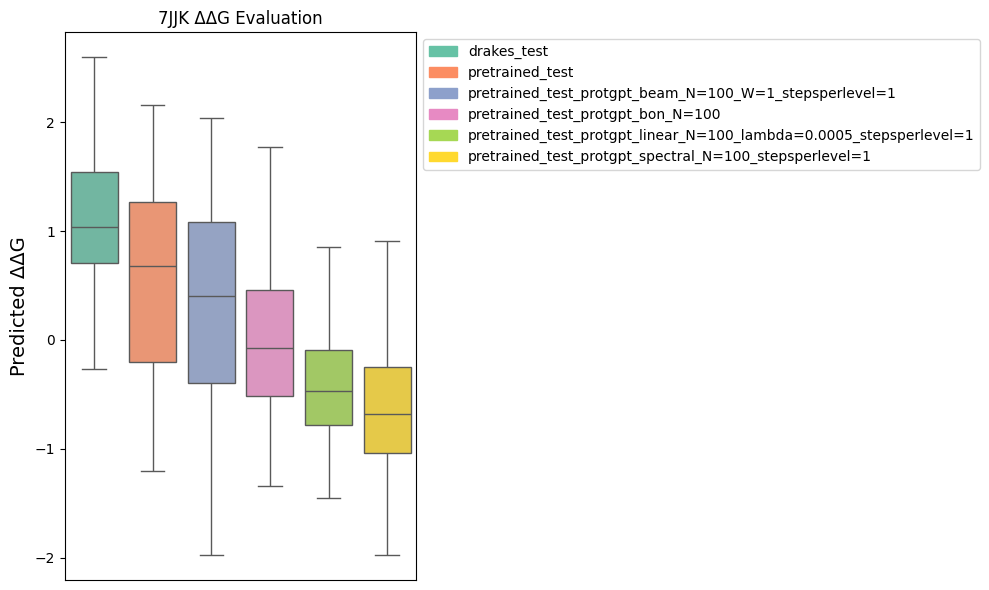

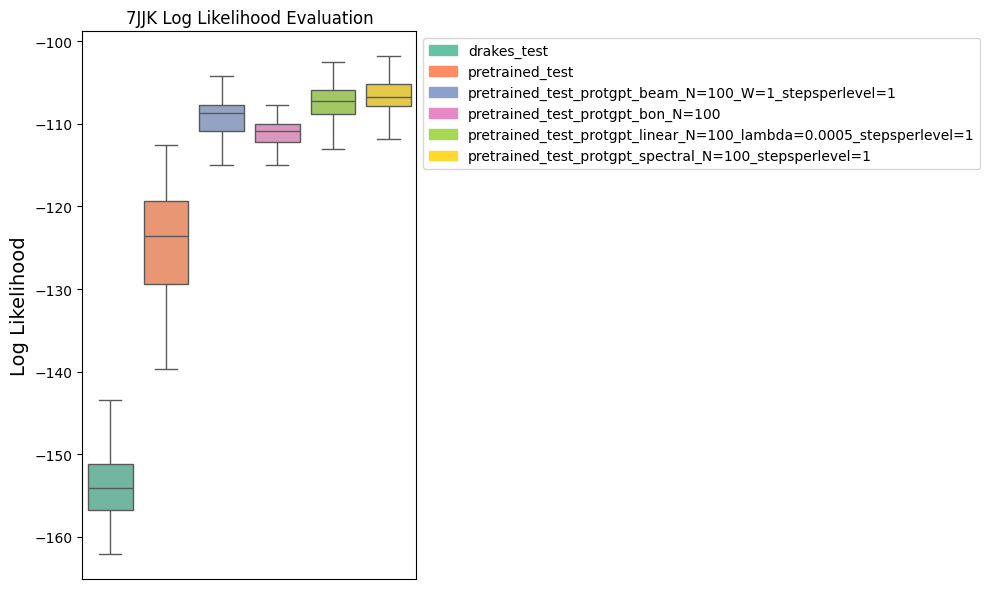

In [ ]:
display_experiments(100, 'protgpt', dataset='test', target_protein='7JJK')

In [46]:
from matplotlib import pyplot as plt
import random 
import numpy as np

def evaluate_ddg_ll_corr_mult(df_list, labels, protein, title='', selected_samples=None):
    for i, df in enumerate(df_list):
        df = df[df['protein_name'] == protein + ".pdb"]
        pre_ddg = df['ddg_eval']
        pre_protgpt = df['loglikelihood']
        if selected_samples is not None and len(pre_ddg) > selected_samples: # type: ignore
            ids = random.sample(range(len(pre_ddg)), selected_samples) # type: ignore
            pre_ddg = np.array(pre_ddg)[ids]
            pre_protgpt = np.array(pre_protgpt)[ids]
        plt.scatter(pre_ddg, pre_protgpt, label=labels[i])
    plt.xlabel('ΔΔG')
    plt.ylabel('Log Likelihood')
    plt.title(title)
    plt.legend()
    plt.show()

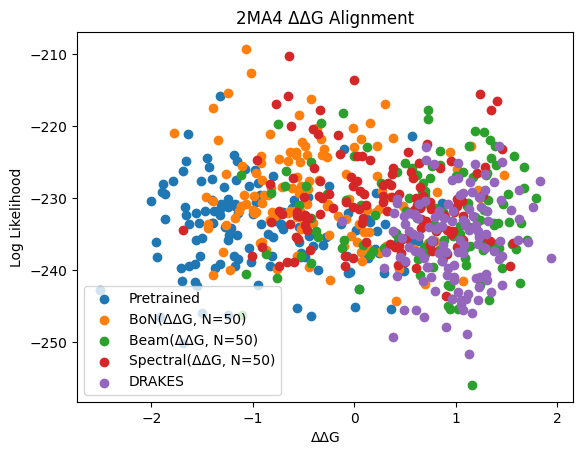

In [52]:
exps = []
bliss_dir = '/home/shai/BLISS_Experiments/DRAKES/'
exp_dir = 'DRAKES/drakes_protein/fmif/eval_results/'
base_path = bliss_dir + exp_dir + 'test' + '/'

exps.append(BLISSExperiment(
    name='Pretrained',
    base_path=base_path,
    model='pretrained',
    dataset='test'))

exps.append(BLISSExperiment(
    name='BoN(ΔΔG, N=50)',
    base_path=base_path,
    model='pretrained',
    dataset='test',
    oracle_mode='ddg',
    align_type='bon',
    align_n=50))

exps.append(BLISSExperiment(
    name='Beam(ΔΔG, N=50)',
    base_path=base_path,
    model='pretrained',
    dataset='test',
    oracle_mode='ddg',
    align_type='beam',
    align_n=50,
    beam_w=1))

exps.append(BLISSExperiment(
    name='Spectral(ΔΔG, N=50)',
    base_path=base_path,
    model='pretrained',
    dataset='test',
    oracle_mode='ddg',
    align_type='spectral',
    align_n=50,
    beam_w=1))

exps.append(BLISSExperiment(
    name='DRAKES',
    base_path=base_path,
    model='drakes',
    dataset='test'))

dfs = [e.get_df() for e in exps]
labels = [e.name for e in exps]

evaluate_ddg_ll_corr_mult(dfs, labels, '2MA4', selected_samples=None, title='2MA4 ΔΔG Alignment')